In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import ast
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("/home/hannah-gc/Downloads/Airbnb_Data.csv")
print(df.head())

2024-09-09 17:25:33.391314: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 17:25:33.391815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 17:25:33.394193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 17:25:33.401010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 17:25:33.412245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

         id  log_price property_type        room_type  \
0   6901257   5.010635     Apartment  Entire home/apt   
1   6304928   5.129899     Apartment  Entire home/apt   
2   7919400   4.976734     Apartment  Entire home/apt   
3  13418779   6.620073         House  Entire home/apt   
4   3808709   4.744932     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   

   bed_type cancellation_policy  cleaning_fee  ...   latitude   longitude  \
0  Real Bed              strict          True  ...  40.696524  -73.991617   
1  Real Bed     

# Data Processing Overview
This project aims to predict Airbnb listing prices (log_price) using various features from the dataset. The processing steps undertaken are as follows:

Feature Utilization: Focused on using geographical (latitude, longitude), categorical (property_type, room_type, bed_type, cancellation_policy), and binary features (cleaning_fee, host_identity_verified, instant_bookable). Other features like description, ID, thumbnail_url, first_review, name, and last_review were excluded from the analysis as they were not relevant towards predicting price.

Categorical Feature Encoding: Applied Label Encoding to transform categorical features into numerical values, making them suitable for model input.

Binary Feature Conversion: Converted binary features to numerical format, facilitating their use in the neural network model.

Amenities Feature Engineering: Extracted and one-hot encoded the amenities from a JSON string, creating binary features for each amenity to capture detailed property characteristics.

Data Normalization: Normalized numerical features such as accommodates, bathrooms, bedrooms, beds, and review_scores_rating to ensure they're on a similar scale for effective model training.

Missing Value Imputation: Implemented median imputation for missing values in bathrooms, bedrooms, beds, and review_scores_rating to maintain data completeness without introducing bias.

Feature Transformation: Adjusted the approach to handling time-related and location-based features. Specifically, location features were streamlined to focus on latitude and longitude for geographical information, and time-related features like first_review and last_review were not used as initially planned.

The model preparation and training aim to leverage these processed features to accurately predict Airbnb listing prices.

Data Exploration


In [4]:
df.shape

(74111, 29)

In [5]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [6]:
df.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [8]:
df.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [9]:
df.isnull().sum()

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64

In [10]:
# Feature columns we will use 'as is' - everything else we will transform and add to X
feature_columns = ["latitude", "longitude"]
X = df[feature_columns].copy()
Y = df[["log_price"]].copy()

# Initialize separate instances of LabelEncoder for each column so we can perform inverse tranformations later
property_type_encoder = LabelEncoder()
room_type_encoder = LabelEncoder()
bed_type_encoder = LabelEncoder()
cancellation_policy_encoder = LabelEncoder()

# Transform categorical features to an int of  0 - N
X["property_type"] = property_type_encoder.fit_transform(df["property_type"])
print("Property Type Classes:", property_type_encoder.classes_)

X["room_type"] = room_type_encoder.fit_transform(df["room_type"])
print("Room Type Classes:", room_type_encoder.classes_)

X["bed_type"] = bed_type_encoder.fit_transform(df["bed_type"])
print("Bed Type Classes:", bed_type_encoder.classes_)

X["cancellation_policy"] = cancellation_policy_encoder.fit_transform(
    df["cancellation_policy"]
)
print("Cancellation Policy Classes:", cancellation_policy_encoder.classes_)



Property Type Classes: ['Apartment' 'Bed & Breakfast' 'Boat' 'Boutique hotel' 'Bungalow' 'Cabin'
 'Camper/RV' 'Casa particular' 'Castle' 'Cave' 'Chalet' 'Condominium'
 'Dorm' 'Earth House' 'Guest suite' 'Guesthouse' 'Hostel' 'House' 'Hut'
 'In-law' 'Island' 'Lighthouse' 'Loft' 'Other' 'Parking Space'
 'Serviced apartment' 'Tent' 'Timeshare' 'Tipi' 'Townhouse' 'Train'
 'Treehouse' 'Vacation home' 'Villa' 'Yurt']
Room Type Classes: ['Entire home/apt' 'Private room' 'Shared room']
Bed Type Classes: ['Airbed' 'Couch' 'Futon' 'Pull-out Sofa' 'Real Bed']
Cancellation Policy Classes: ['flexible' 'moderate' 'strict' 'super_strict_30' 'super_strict_60']


In [11]:
# Transforming binary features
X["cleaning_fee"] = df["cleaning_fee"].astype(int)


In [12]:
# These are in the dataset as 't'/'f' instead of True / False
X["host_identity_verified"] = df["host_identity_verified"].map({"t": 1, "f": 0})
X["instant_bookable"] = df["instant_bookable"].map({"t": 1, "f": 0})


In [13]:

# List of amenities to exclude - seems to be some bad data
amenities_to_exclude = [
    "translation missing: en.hosting_amenity_49",
    "translation missing: en.hosting_amenity_50",
]

def parse_amenities(amenities_str):
    """
    Converts the amenities string into a python list
    """
    try:
        # Convert the stringified list to a list
        amenities_list = ast.literal_eval(amenities_str.replace('"', "'"))
        # Filter out the amenities to exclude
        filtered_amenities = [
            amenity for amenity in amenities_list if amenity not in amenities_to_exclude
        ]
        return filtered_amenities
    except ValueError:
        return []


In [14]:
# Amenities is a JSON string - to actually use this in our neural network, we're going to one-hot encode all these features
df["amenities"] = df["amenities"].apply(parse_amenities)

In [15]:
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the amenities lists to a one-hot encoded matrix
amenities_encoded = mlb.fit_transform(df["amenities"])

# Create a DataFrame from the encoded matrix, with column names as the unique amenities
amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_)

# Concatenate the original DataFrame with the new one-hot encoded amenities DataFrame
X = pd.concat([X, amenities_df], axis=1)
print("One-Hot Encoded Amenities: ", mlb.classes_)

One-Hot Encoded Amenities:  ['24-hour check-in' 'Air conditioning' 'Buzzer/wireless intercom'
 'Cable TV' 'Carbon monoxide detector' 'Doorman Entry'
 'Elevator in building' 'Family/kid friendly' 'Fire extinguisher'
 'First aid kit' 'Free parking on premises' 'Host greets you' 'Hot tub'
 'Laptop friendly workspace' 'Lock on bedroom door' 'Pets allowed'
 'Pets live on this property' 'Safety card' 'Self Check-In' 'Smart lock'
 'Smoke detector' 'Smoking allowed' 'Suitable for events'
 'Wheelchair accessible' 'Wireless Internet']


In [16]:
# Normalize features
scaler = StandardScaler()
X["accommodates"] = scaler.fit_transform(df[["accommodates"]])
X["bathrooms"] = scaler.fit_transform(df[["bathrooms"]])
X["number_of_reviews"] = scaler.fit_transform(df[["number_of_reviews"]])
X["review_scores_rating"] = scaler.fit_transform(df[["review_scores_rating"]])
X["bedrooms"] = scaler.fit_transform(df[["bedrooms"]])
X["beds"] = scaler.fit_transform(df[["beds"]])

In [17]:
# Imputation for bathrooms, bedrooms, and beds with median
for column in ["bathrooms", "bedrooms", "beds"]:
    X[column] = X[column].fillna(X[column].median())

In [18]:
# Handling review_scores_rating and host_identity_verified with an indicator and median imputation
X["review_scores_rating_missing"] = X["review_scores_rating"].isnull().astype(int)
X["review_scores_rating"] = X["review_scores_rating"].fillna(
    X["review_scores_rating"].median()
)

X["host_identity_verified"] = X["host_identity_verified"].isnull().astype(int)
X["review_scores_rating"] = X["review_scores_rating"].fillna(
    X["review_scores_rating"].median()
)


In [19]:
# Applying consistency towards column names
def to_snake_case(name):
    # Replace spaces and hyphens with underscores
    s1 = re.sub(r"[\s-]+", "_", name)
    # Convert CamelCase to snake_case
    s2 = re.sub(r"(.)([A-Z][a-z]+)", r"\1_\2", s1)
    s3 = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", s2).lower()
    # Replace special characters with underscore
    s4 = re.sub(r"[^a-zA-Z0-9_]", "_", s3)
    # Collapse multiple underscores into one
    return re.sub(r"__+", "_", s4)

# Convert all these columns to snake case for consistency
X.rename(columns={col: to_snake_case(col) for col in X.columns}, inplace=True)

# Visualizations

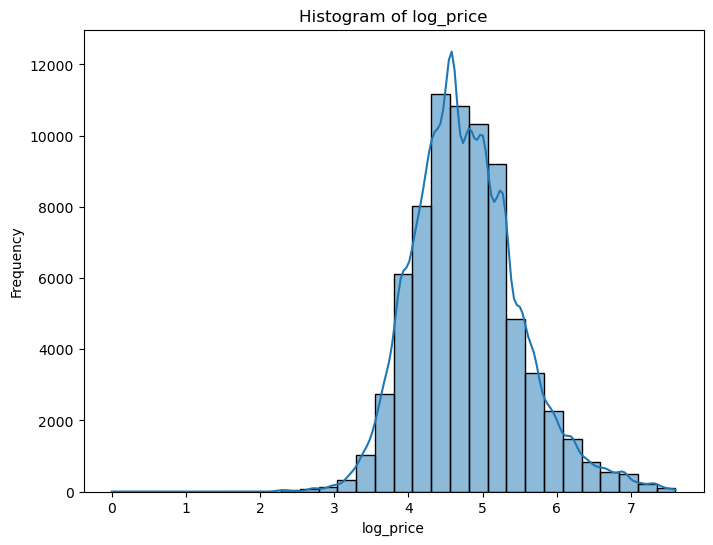

In [21]:
#  Histogram of Target Variable (log_price)
plt.figure(figsize=(8, 6))
sns.histplot(df['log_price'], bins=30, kde=True)
plt.title('Histogram of log_price')
plt.xlabel('log_price')
plt.ylabel('Frequency')
plt.show()

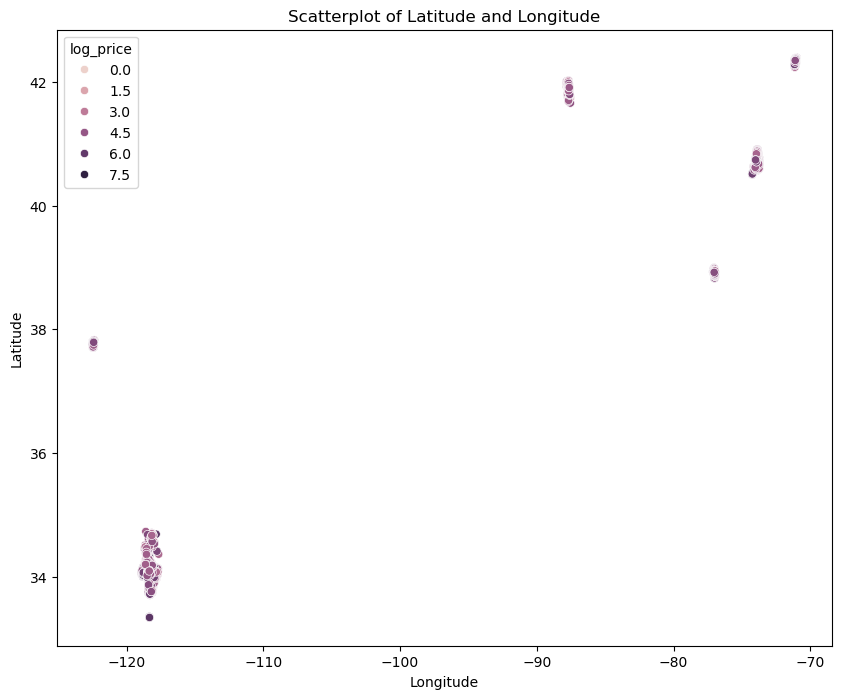

In [22]:
# Scatterplot of Latitude and Longitude
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='log_price')
plt.title('Scatterplot of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

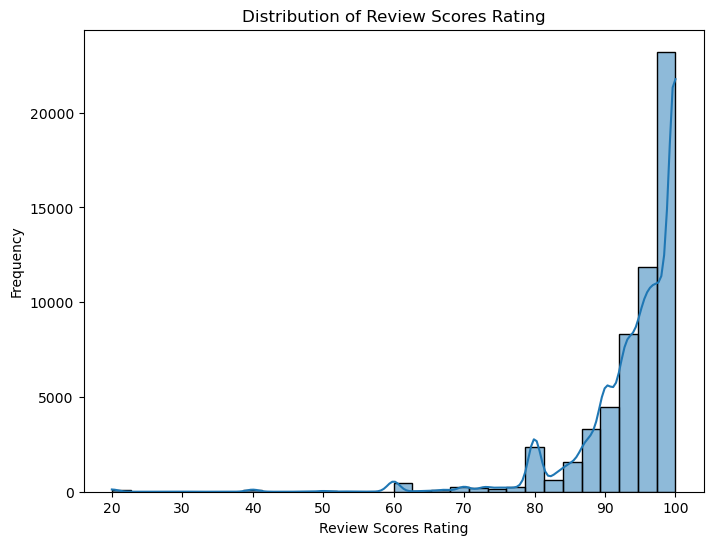

In [23]:
#  Distribution of Review Scores Rating
plt.figure(figsize=(8, 6))
sns.histplot(df['review_scores_rating'], bins=30, kde=True)
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Frequency')
plt.show()

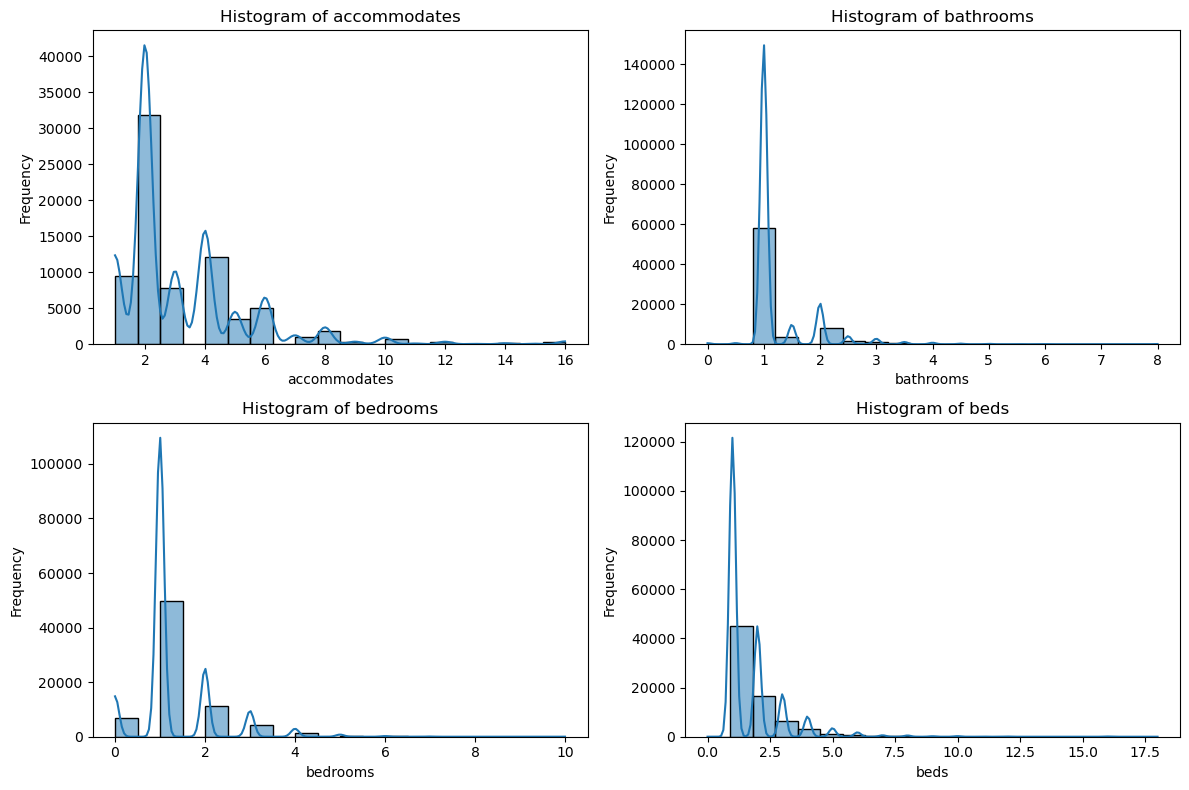

In [24]:
# Histogram of Accommodates, Bathrooms, Bedrooms, Beds
num_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], bins=20, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

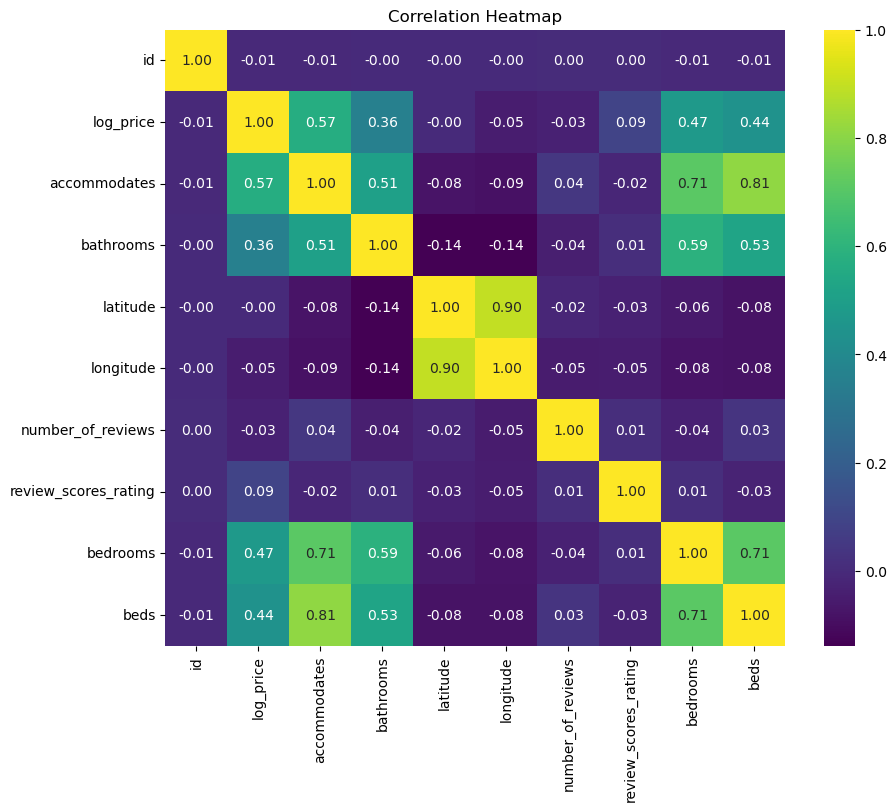

Highly correlated pairs of columns:
('accommodates', 'bedrooms')
('accommodates', 'beds')
('latitude', 'longitude')
('bedrooms', 'beds')


In [25]:
# Define numerical features
numerical_features = df.select_dtypes(include=np.number).columns

# Compute the correlation matrix
corr_matrix = df[numerical_features].corr()

# Generate a heatmap with a different colormap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# threshold for high correlation
threshold = 0.7

# Find highly correlated pairs
high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)

# Extract the column names of highly correlated pairs
high_corr_columns = [(numerical_features[i], numerical_features[j]) for i, j in zip(*high_corr_pairs) if i != j and i < j]

# Print the highly correlated pairs of columns
print("Highly correlated pairs of columns:")
for pair in high_corr_columns:
    print(pair)


Splitting the Data

In [27]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_train, x_, y_train, y_ = train_test_split(X, Y, test_size=0.40, random_state=80)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)

Neural Network Model Definition

In [29]:
# Setting the random seed for reproducibility
tf.random.set_seed(1234)

def build_model(dropout1, dropout2):
    model = Sequential([
        Dense(128, activation='relu'),
        Dropout(dropout1),
        Dense(64, activation='relu'),
        Dropout(dropout2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Defining dropout rates to test
dropout_options = [(0.3, 0.1), (0.5, 0.2), (0.5, 0.3)]  # Pairs of dropout rates

# Looping over combinations of hyperparameters
best_val_mae = float('inf')
best_config = None

for dropout1, dropout2 in dropout_options:
    print(f"Testing model with dropout rates: {dropout1}, {dropout2}")
    # Build and train model
    model = build_model(dropout1, dropout2)
    model.fit(x_train, y_train, epochs=10, validation_data=(x_cv, y_cv), verbose=0)
    # Evaluate model on cross-validation data
    val_loss, val_mae = model.evaluate(x_cv, y_cv, verbose=0)
    print(f"Cross-validation MAE: {val_mae}")

    # Updating the best model if current model is better
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_config = (dropout1, dropout2)

print(f"Best configuration: Dropout rates {best_config}")
print(f"Best cross-validation MAE: {best_val_mae}")

# Evaluating the best model on the test set
best_model = build_model(best_config[0], best_config[1])
best_model.fit(x_train, y_train, epochs=10, verbose=0)  # Re-train the best model
test_loss, test_mae = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

Testing model with dropout rates: 0.3, 0.1
Cross-validation MAE: 0.49625900387763977
Testing model with dropout rates: 0.5, 0.2
Cross-validation MAE: 0.40075361728668213
Testing model with dropout rates: 0.5, 0.3
Cross-validation MAE: 0.4572020173072815
Best configuration: Dropout rates (0.5, 0.2)
Best cross-validation MAE: 0.40075361728668213
Test MAE: 0.4142126739025116


# Model Compilation and Training
Compiling the best model found from above hypertuning, with the Mean Squared Error loss function and Adam optimizer, and training it with early stopping to prevent overfitting.

In [31]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

history = best_model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_cv, y_cv),
    callbacks=[early_stopping],
)

best_model.summary()

# Predicting the test set results
y_pred = best_model.predict(x_test)

Epoch 1/100
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2536 - mean_absolute_error: 0.3832 - val_loss: 0.3097 - val_mean_absolute_error: 0.4151
Epoch 2/100
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2526 - mean_absolute_error: 0.3834 - val_loss: 0.3027 - val_mean_absolute_error: 0.4097
Epoch 3/100
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2534 - mean_absolute_error: 0.3826 - val_loss: 0.2987 - val_mean_absolute_error: 0.4083
Epoch 4/100
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 0.2527 - mean_absolute_error: 0.3825 - val_loss: 0.2997 - val_mean_absolute_error: 0.4077
Epoch 5/100
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2507 - mean_absolute_error: 0.3813 - val_loss: 0.2990 - val_mean_absolute_error: 0.4071
Epoch 6/100
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2503 - mean_absolute_error: 0.3805 - val_loss: 0.2959 - val_mean_absolute_error: 0.4051
Epoch 7/100
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2499 - mean_abs

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,237 (184.52 KB)

 Trainable params: 15,745 (61.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,492 (123.02 KB)

464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


In [32]:
# neural network evaluation metrics: calculating r2_score, mean_absoulte_error, mean_squared_error

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)


# Print the scores
print("R^2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


R^2 Score: 0.4703726872823496
Mean Absolute Error (MAE): 0.3924934003676238
Mean Squared Error (MSE): 0.2735549179104835
Root Mean Squared Error (RMSE): 0.5230247775301696


In [33]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Create RandomizedSearchCV instance
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10,
                                   cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

# Perform randomized search
random_search.fit(x_train, y_train.values.ravel())

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_rf_model = random_search.best_estimator_

# Predicting the test set results using the best model
y_pred_rf_tuned = best_rf_model.predict(x_test)

# Calculate evaluation metrics for the tuned model
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)

# Print the scores for the tuned model
print("Tuned Random Forest - R^2 Score:", r2_rf_tuned)
print("Tuned Random Forest - Mean Absolute Error (MAE):", mae_rf_tuned)
print("Tuned Random Forest - Mean Squared Error (MSE):", mse_rf_tuned)
print("Tuned Random Forest - Root Mean Squared Error (RMSE):", rmse_rf_tuned)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}
Tuned Random Forest - R^2 Score: 0.6901662148047774
Tuned Random Forest - Mean Absolute Error (MAE): 0.28679890577531064
Tuned Random Forest - Mean Squared Error (MSE): 0.1600305604332722
Tuned Random Forest - Root Mean Squared Error (RMSE): 0.4000381987176627


In [34]:
# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'alpha': [0.1, 1.0, 10.0]  # Regularization strength
}

# Create a Ridge Regression model
ridge_reg = Ridge()

# Create GridSearchCV instance
np.random.seed(42)
grid_search = GridSearchCV(estimator=ridge_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_ridge_model = grid_search.best_estimator_

# Predicting the test set results using the best model
y_pred_ridge = best_ridge_model.predict(x_test)

# Calculate evaluation metrics for the model
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

# Print the scores for the model
print("Tuned Ridge Regression - R^2 Score:", r2_ridge)
print("Tuned Ridge Regression - Mean Absolute Error (MAE):", mae_ridge)
print("Tuned Ridge Regression - Mean Squared Error (MSE):", mse_ridge)
print("Tuned Ridge Regression - Root Mean Squared Error (RMSE):", rmse_ridge)


Best Parameters: {'alpha': 10.0}
Tuned Ridge Regression - R^2 Score: 0.5353829738135707
Tuned Ridge Regression - Mean Absolute Error (MAE): 0.37100603369421964
Tuned Ridge Regression - Mean Squared Error (MSE): 0.23997680898681104
Tuned Ridge Regression - Root Mean Squared Error (RMSE): 0.4898742787561019


In [35]:
# KNN Model
from sklearn.neighbors import KNeighborsRegressor

# Find best k hyperparameter
for k_value in [3, 5, 7, 10]:
    knn_classifier = KNeighborsRegressor(n_neighbors=k_value)
    knn_classifier.fit(x_train, y_train)
    y_pred = knn_classifier.predict(x_test)
    mse_knn_model = mean_squared_error(y_test, y_pred)
    print("Classification MSE with k =", k_value, ":", mse_knn_model)


Classification MSE with k = 3 : 0.25529250603245157
Classification MSE with k = 5 : 0.23585958221749723
Classification MSE with k = 7 : 0.22930224310623587
Classification MSE with k = 10 : 0.2255180342734296


In [36]:
# Setting up KNN regressor according to the best value of k from above results
knn_model = KNeighborsRegressor(n_neighbors=5)

# Fitting the model
knn_model.fit(x_train, y_train)

# Predicting and evaluating
y_pred_knn = knn_model.predict(x_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("KNN Mean Squared Error:", mse_knn)
print("KNN Root Mean Squared Error:", rmse_knn)
print("KNN Mean Absolute Error:", mae_knn)
print("KNN R Squared Error:", r2_knn)


KNN Mean Squared Error: 0.23585958221749723
KNN Root Mean Squared Error: 0.4856537678403177
KNN Mean Absolute Error: 0.36455935986169463
KNN R Squared Error: 0.5433543009837676


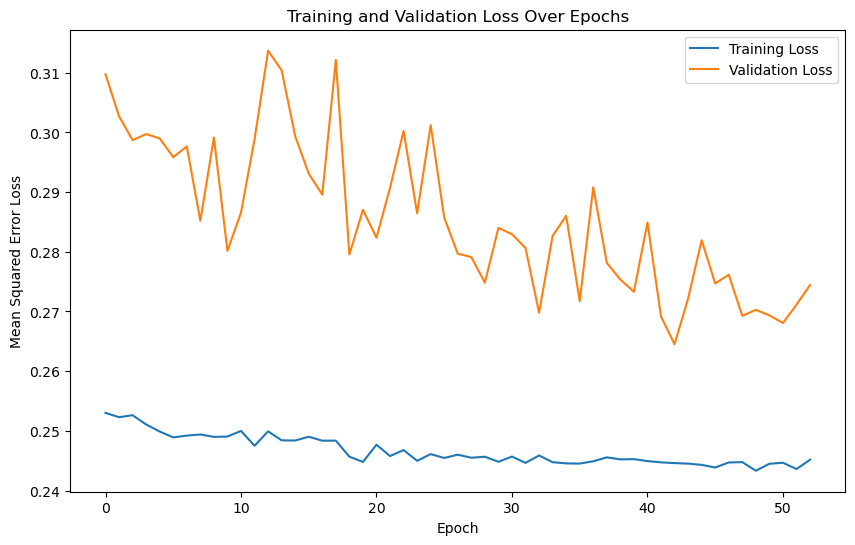

In [37]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
plt.show()

In [38]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Initialize DT model
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.40, random_state=42)
tree = DecisionTreeRegressor(random_state=42)

# Hyperparameter tuning
params_dt = {'max_depth': [5, 7, 10, 12],
             'min_samples_split': [2, 3, 4, 5],
             'max_features': ['sqrt', 'log2']}
gcv_dt = GridSearchCV(tree, params_dt, n_jobs=-1, cv=5)
gcv_dt.fit(X, Y)

# Print best parameters
print(gcv_dt.best_params_)

# Use best estimator
dt_model = gcv_dt.best_estimator_

# Fit model
dt_model.fit(x_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(x_test)

# Calculate metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Print metrics
print("Decision Tree Mean Squared Error:", mse_dt)
print("Decision Tree Root Mean Squared Error:", rmse_dt)
print("Decision Tree Mean Absolute Error:", mae_dt)
print("Decision Tree R^2 Value:", r2_dt)

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 2}
Decision Tree Mean Squared Error: 0.23277675432359282
Decision Tree Root Mean Squared Error: 0.4824694335640268
Decision Tree Mean Absolute Error: 0.35691377620837145
Decision Tree R^2 Value: 0.5476542860051975


In [39]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 6.5 MB/s eta 0:00:00 MB/s eta 0:00:01:01


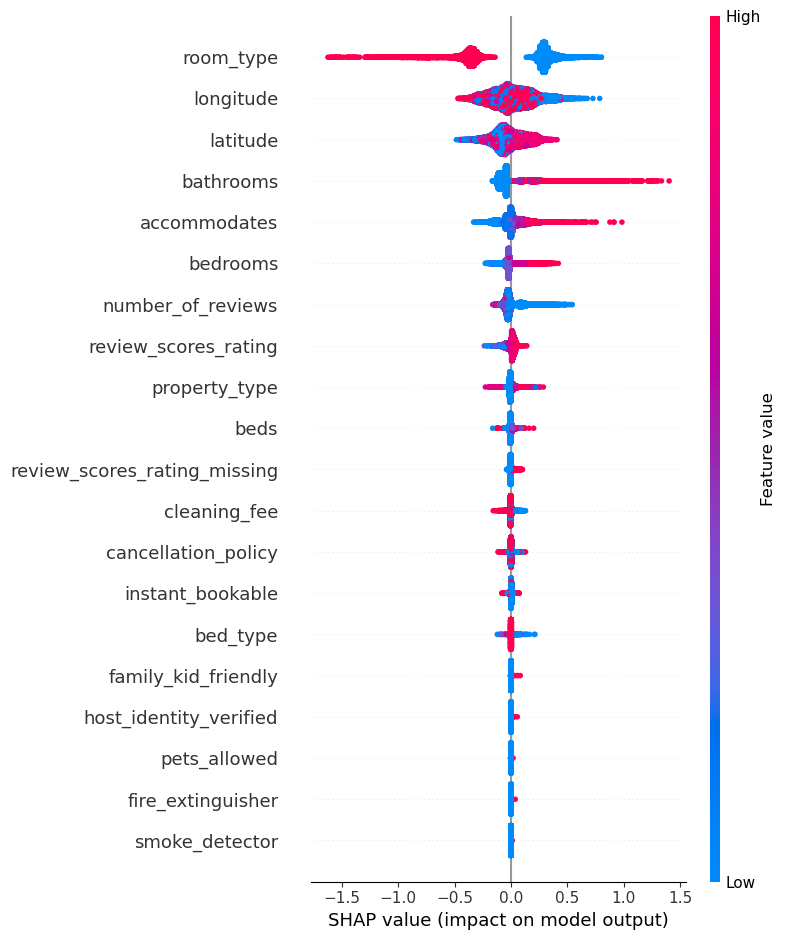

In [40]:
# Show shap values of best model (Random Forest)
import shap
explainer = shap.Explainer(best_rf_model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)